In [3]:
!pip install stop_words
!pip install pymorphy2

In [4]:
import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import string
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [5]:
!unzip data.zip

Archive:  data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/data/._val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")

In [7]:
df_test.head(10)

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."
5,204155,в Питере какой то Сайлент Хилл) http://t.co/gB...
6,204156,@Brokerrr2 ухты какой молодец)) ахаха) а ты со...
7,204157,"Мальчишки-кадеты, осталось детство где-то.))\n..."
8,204158,RT @MrFarneo: Было жутко больно :-/ http://t.c...
9,204159,Ромка что то раздобрел и купилмне киндер) Стра...


In [8]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [9]:
def text_cleaning(text):
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    text = re.sub(' +', ' ', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [10]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)


In [11]:
hw_train = df_train
hw_val = df_val
hw_test = df_test
my_train = df_train
my_val = df_val
my_test = df_test

In [12]:
hw_train['text'] = df_train['text'].apply(preprocess_text)
hw_val['text'] = df_val['text'].apply(preprocess_text)
hw_test['text'] = df_test['text'].apply(preprocess_text)

In [13]:
my_train['text'] = df_train['text'].apply(text_cleaning)
my_val['text'] = df_val['text'].apply(text_cleaning)
my_test['text'] = df_test['text'].apply(text_cleaning)

Part with hw

In [14]:
text_corpus_train = hw_train['text'].values
text_corpus_valid = hw_val['text'].values
text_corpus_test = hw_test['text'].values

In [15]:
tokenizer = Tokenizer(num_words=10000, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [16]:
y_train = hw_train['class'].values
y_val = hw_val['class'].values

# CNN model for sentimental analyzis

In [17]:
X_train.shape

(181467, 21)

In [18]:
cnn_model = Sequential()

cnn_model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
cnn_model.add(Masking(mask_value=0.0))
cnn_model.add(Conv1D(128, 4))
cnn_model.add(Activation("relu"))
cnn_model.add(Conv1D(128, 4))
cnn_model.add(Activation("relu"))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 30)            3058320   
_________________________________________________________________
masking (Masking)            (None, 21, 30)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 18, 128)           15488     
_________________________________________________________________
activation (Activation)      (None, 18, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 128)           65664     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0

In [19]:
early_stopping=EarlyStopping(monitor='accuracy')  


history = cnn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                   )# callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 20s 7ms/step - loss: 0.6307 - accuracy: 0.6058 - val_loss: 0.6074 - val_accuracy: 0.6233
Epoch 2/10
319/319 [==============================] - 2s 6ms/step - loss: 0.5876 - accuracy: 0.6427 - val_loss: 0.6055 - val_accuracy: 0.6300
Epoch 3/10
319/319 [==============================] - 2s 6ms/step - loss: 0.5702 - accuracy: 0.6516 - val_loss: 0.6273 - val_accuracy: 0.6281
Epoch 4/10
319/319 [==============================] - 2s 6ms/step - loss: 0.5603 - accuracy: 0.6565 - val_loss: 0.6341 - val_accuracy: 0.6305
Epoch 5/10
319/319 [==============================] - 2s 7ms/step - loss: 0.5518 - accuracy: 0.6608 - val_loss: 0.6608 - val_accuracy: 0.6283
Epoch 6/10
319/319 [==============================] - 2s 7ms/step - loss: 0.5446 - accuracy: 0.6648 - val_loss: 0.6822 - val_accuracy: 0.6272
Epoch 7/10
319/319 [==============================] - 2s 6ms/step - loss: 0.5385 - accuracy: 0.6675 - val_loss: 0.7132 - val_accuracy: 0.6276
Epoch

In [20]:
score = cnn_model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 3ms/step - loss: 0.7623 - accuracy: 0.6202


Test score: 0.7623131275177002
Test accuracy: 0.6202001571655273


In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

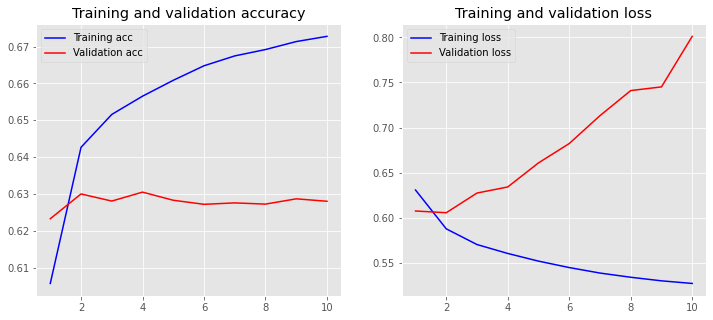

In [22]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [23]:
cnn_model = Sequential()

cnn_model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
cnn_model.add(Masking(mask_value=0.0))
cnn_model.add(Activation("relu"))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 30)            3058320   
_________________________________________________________________
masking_1 (Masking)          (None, 21, 30)            0         
_________________________________________________________________
activation_2 (Activation)    (None, 21, 30)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               15872     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [24]:
early_stopping=EarlyStopping(monitor='accuracy')  


history = cnn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1
                   )# callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 2s 5ms/step - loss: 0.6335 - accuracy: 0.6041 - val_loss: 0.6148 - val_accuracy: 0.6246
Epoch 2/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5939 - accuracy: 0.6401 - val_loss: 0.6077 - val_accuracy: 0.6287
Epoch 3/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5753 - accuracy: 0.6487 - val_loss: 0.6141 - val_accuracy: 0.6278
Epoch 4/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5676 - accuracy: 0.6515 - val_loss: 0.6205 - val_accuracy: 0.6289
Epoch 5/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5625 - accuracy: 0.6537 - val_loss: 0.6308 - val_accuracy: 0.6273
Epoch 6/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5591 - accuracy: 0.6552 - val_loss: 0.6395 - val_accuracy: 0.6289
Epoch 7/10
319/319 [==============================] - 1s 4ms/step - loss: 0.5563 - accuracy: 0.6561 - val_loss: 0.6473 - val_accuracy: 0.6283
Epoch 

In [25]:
score = cnn_model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 2ms/step - loss: 0.6522 - accuracy: 0.6236


Test score: 0.6521788835525513
Test accuracy: 0.6235947608947754


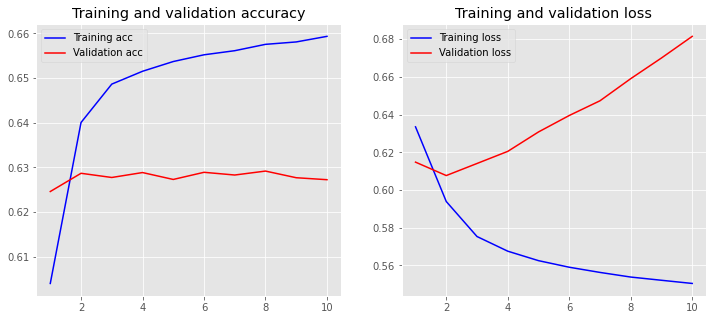

In [26]:
plot_history(history)

In [29]:
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, MaxPooling1D, Flatten
# define model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
cnn_model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
print(cnn_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 30)            3058320   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 32)            7712      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2250      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 3,068,293
Trainable params: 3,068,293
Non-trainable params: 0
____________________________________________

In [32]:

cnn_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()
early_stopping=EarlyStopping(monitor='accuracy')  


history = cnn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1
                   )# callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 21, 30)            3058320   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 14, 32)            7712      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2250      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 3,068,293
Trainable params: 3,068,293
Non-trainable params: 0
____________________________________________

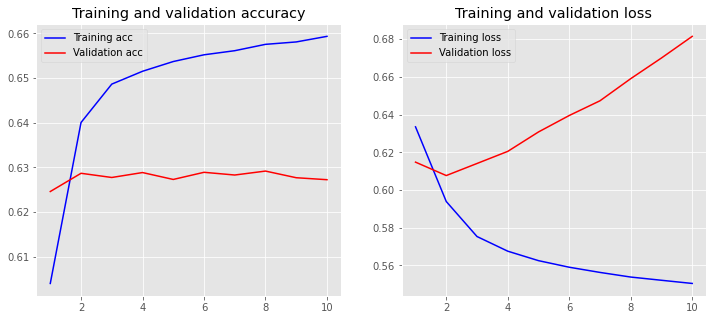

In [31]:
plot_history(history)

RNN MODEL

In [33]:
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, Flatten
# define model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Flatten())
rnn_model.add(Dense(10, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))
print(rnn_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 21, 30)            3058320   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 3,065,061
Trainable params: 3,065,061
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
rnn_model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
early_stopping=EarlyStopping(monitor='accuracy')  


history = rnn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1
                   )# callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 11s 32ms/step - loss: 0.6240 - accuracy: 0.6151 - val_loss: 0.6068 - val_accuracy: 0.6300
Epoch 2/10
319/319 [==============================] - 11s 33ms/step - loss: 0.5826 - accuracy: 0.6449 - val_loss: 0.6075 - val_accuracy: 0.6301
Epoch 3/10
319/319 [==============================] - 10s 32ms/step - loss: 0.5650 - accuracy: 0.6538 - val_loss: 0.6178 - val_accuracy: 0.6292
Epoch 4/10
319/319 [==============================] - 10s 31ms/step - loss: 0.5536 - accuracy: 0.6578 - val_loss: 0.6281 - val_accuracy: 0.6265
Epoch 5/10
319/319 [==============================] - 10s 31ms/step - loss: 0.5467 - accuracy: 0.6604 - val_loss: 0.6398 - val_accuracy: 0.6281
Epoch 6/10
319/319 [==============================] - 10s 31ms/step - loss: 0.5427 - accuracy: 0.6616 - val_loss: 0.6490 - val_accuracy: 0.6257
Epoch 7/10
319/319 [==============================] - 10s 33ms/step - loss: 0.5398 - accuracy: 0.6631 - val_loss: 0.6617 - val_accuracy:

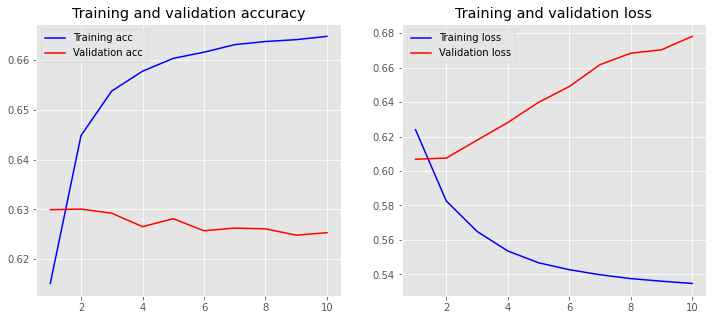

In [36]:
plot_history(history)

In [37]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 29s 85ms/step - loss: 0.6340 - accuracy: 0.6058 - val_loss: 0.6084 - val_accuracy: 0.6256


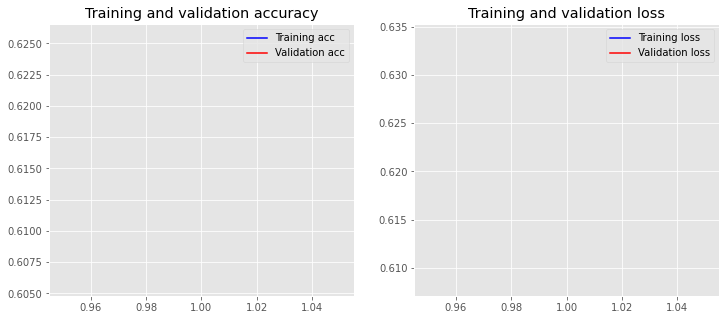

In [38]:
plot_history(history)

In [39]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 26s 76ms/step - loss: 0.6316 - accuracy: 0.6089 - val_loss: 0.6086 - val_accuracy: 0.6279


3. построить совместные архитектуры CNN -> RNN и (RNN -> CNN)

In [42]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(Conv1D(128, 4))
model.add(Activation("relu"))
model.add(GRU(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 19s 53ms/step - loss: 0.6286 - accuracy: 0.6074 - val_loss: 0.6069 - val_accuracy: 0.6265
